---
# Imports

In [1]:
import json
from rich import print as rprint
import pandas as pd
import numpy as np

import warnings
# Filter the specific UserWarning from torch regarding TF32/matmul precision
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

import torch
torch.set_float32_matmul_precision('high')
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes, make_rgb_axes
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import cv2
from tqdm import tqdm
import pickle

print('OpenCV version: ', cv2.__version__)

OpenCV version:  4.12.0


In [2]:
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

seed_everything(42)


---
# Load data

In [3]:
# Read Training Data CSV
df_train = pd.read_csv('../data/raw/Training/Train.csv')

In [4]:
# Drop image 332 due to corrupted file
df_train = df_train[df_train['image_id'] != 332].reset_index(drop=True)

In [5]:
# Load augmented data

with open('../data/processed/augmented/augmented_train_masked_local_depth_480.pkl', 'rb') as f:
    aug_train = pickle.load(f)

---

In [6]:
# Ensuring all 31 versions of an image are together in the train/val split (avoid data leakage between sets)
# Stratify by bins of FreshWeightShoot
# Stratify by Variety

In [7]:
def prepare_folds_from_array(aug_array, n_splits=5):
    """
    Groups augmented samples by image_id and assigns folds 
    stratified by Variety and DryWeightShoot bins.
    """
    # 1. Extract metadata for the 230 unique plants
    items = []
    seen_ids = set()
    for s in aug_array:
        if s['image_id'] not in seen_ids:
            items.append({
                'image_id': s['image_id'],
                'dry_weight': s['dry_weight'],
                'variety': s['variety']
            })
            seen_ids.add(s['image_id'])
    
    df_meta = pd.DataFrame(items)

    # 2. Create stratification bins based on DSW
    df_meta['weight_bin'] = pd.qcut(df_meta['dry_weight'], q=10, labels=False, duplicates='drop')
    
    # 3. Create composite key (Variety + Weight)
    df_meta['stratify_key'] = df_meta['variety'].astype(str) + "_" + df_meta['weight_bin'].astype(str)
    
    # 4. Perform Stratified Group K-Fold
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    df_meta['fold'] = -1
    
    for fold, (_, val_idx) in enumerate(sgkf.split(df_meta, df_meta['stratify_key'], groups=df_meta['image_id'])):
        df_meta.loc[df_meta.index[val_idx], 'fold'] = fold
        
    return dict(zip(df_meta['image_id'], df_meta['fold'])), df_meta

def get_fold_data(aug_array, fold_map, fold_index):
    """
    Uses the fold_map to split the full augmented array.
    """
    fold_train = [s for s in aug_array if fold_map[s['image_id']] != fold_index]
    fold_val = [s for s in aug_array if fold_map[s['image_id']] == fold_index]
            
    return fold_train, fold_val

---
# Train classifier using seresnet

In [8]:
class LettuceVarietyClassifier(nn.Module):
    def __init__(self, num_classes=4): # 4 varieties
        super().__init__()
        self.backbone = timm.create_model(
            'legacy_seresnet18.in1k', 
            pretrained=True, 
            num_classes=num_classes
        )

    def forward(self, x):
        return self.backbone(x)

In [9]:
class LettuceCombinedDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
        # Standard ImageNet stats for the RGB branch
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # --- RGB Branch ---
        rgb = item['rgb_image']
        rgb = rgb.astype(np.float32) / 255.0
        # Normalize: (x - mean) / std
        rgb = (rgb - self.mean) / self.std
        rgb = np.transpose(rgb, (2, 0, 1)) # HWC to CHW
        rgb_tensor = torch.from_numpy(rgb)
        
        # --- Depth Branch ---
        depth = item['depth_image'].astype(np.float32)
        if len(depth.shape) == 2:
            depth = np.expand_dims(depth, axis=0)
        
        # Normalize uint8 (0-255) to [0, 1]
        if depth.max() > 1.0:
            depth /= 255.0
            
        depth_tensor = torch.from_numpy(depth)
            
        # --- Metadata & Target ---
        # Ensure we use 'item' (the variable defined at the top of this method)
        target = torch.tensor(float(item['dry_weight']), dtype=torch.float)
        variety = item['variety']
        image_id = item['image_id']
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'target': target,
            'variety': variety,
            'image_id': image_id
        }

In [10]:
def train_variety_classifier(fold_idx, train_data, val_data, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    variety_list = ['Aphylion', 'Lugano', 'Salanova', 'Satine']
    variety_map = {v: i for i, v in enumerate(variety_list)}
    
    # 1. Compute Class Weights
    train_labels = [s['variety'] for s in train_data]
    weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.array(variety_list), 
        y=train_labels
    )
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    
    # 2. Setup Model & Loss
    model = LettuceVarietyClassifier(num_classes=4).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    train_loader = DataLoader(LettuceCombinedDataset(train_data), batch_size=32, shuffle=True)
    val_loader = DataLoader(LettuceCombinedDataset(val_data), batch_size=32, shuffle=False)

    best_acc = 0.0
    save_path = f"../weights/variety_classifier_fold_{fold_idx}.pth"

    print(f"--- Training Variety Classifier | Fold {fold_idx} | Weights: {weights.round(2)} ---")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs = batch['rgb'].to(device).float()
            labels = torch.tensor([variety_map[v] for v in batch['variety']], dtype=torch.long).to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        # 3. Validation Check
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['rgb'].to(device).float()
                labels = torch.tensor([variety_map[v] for v in batch['variety']], dtype=torch.long).to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {accuracy:.2f}%")

        # 4. Save Best Model
        if accuracy >= best_acc:
            best_acc = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'accuracy': accuracy,
                'variety_map': variety_map
            }, save_path)
    
    print(f"Fold {fold_idx} Complete. Best Val Acc: {best_acc:.2f}% | Saved to: {save_path}")
    return model

In [11]:
# Quick check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LettuceVarietyClassifier(num_classes=4).to(device)
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Output features: {test_output.shape[-1]}") # Should print 4

Output features: 4


In [12]:
# Generate the map (Run this once)
fold_map, _ = prepare_folds_from_array(aug_train)

# Get data for just the first diagnostic fold
train_fold0, val_fold0 = get_fold_data(aug_train, fold_map, fold_index=0)

# Quick check: Are the varieties actually balanced in Val?
from collections import Counter
val_counts = Counter([s['variety'] for s in val_fold0])
print(f"Validation Variety Distribution: {val_counts}")

Validation Variety Distribution: Counter({'Satine': 403, 'Aphylion': 372, 'Salanova': 372, 'Lugano': 279})


/home/grant/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Train classifier on this fold
classifier_model = train_variety_classifier(0, train_fold0, val_fold0)

---

# Inference

In [14]:
def load_expert_model(fold_idx, device='cuda'):
    # 2. Instantiate the class
    model = LettuceVarietyClassifier(num_classes=4)
    
    # 3. Load the checkpoint
    checkpoint_path = f"../weights/variety_classifier_fold_{fold_idx}.pth"
    
    # Use map_location to handle loading weights across different hardware (e.g., A100 to Laptop)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # If you saved the full dictionary, access the 'model_state_dict'
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded best model from {checkpoint_path} (Acc: {checkpoint.get('accuracy', 'N/A')})")
    else:
        # Fallback if only the state_dict was saved
        model.load_state_dict(checkpoint)
        print(f"Successfully loaded state_dict from {checkpoint_path}")
    
    model.to(device)
    model.eval() # Set to evaluation mode for inference
    return model

# Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = load_expert_model(fold_idx=0, device=device)

Successfully loaded best model from ../weights/variety_classifier_fold_0.pth (Acc: 100.0)


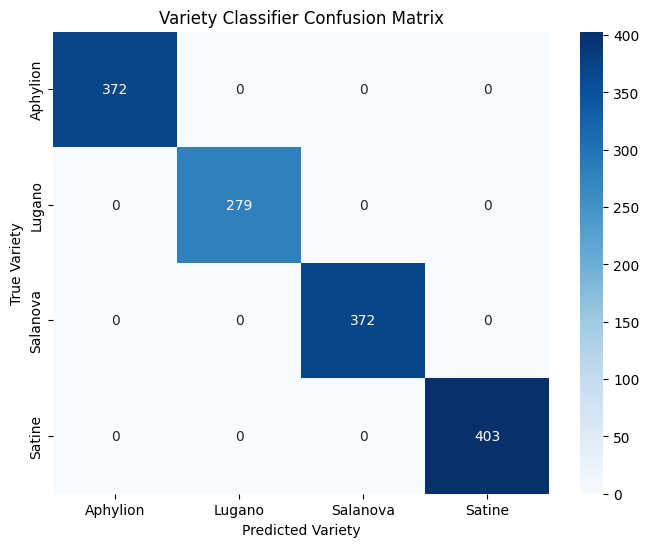

In [15]:
def plot_confusion_matrix(model, val_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    variety_list = ['Aphylion', 'Lugano', 'Salanova', 'Satine']
    variety_map = {v: i for i, v in enumerate(variety_list)}
    
    all_preds = []
    all_labels = []
    
    val_loader = DataLoader(LettuceCombinedDataset(val_data), batch_size=32, shuffle=False)
    
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['rgb'].to(device).float()
            labels = torch.tensor([variety_map[v] for v in batch['variety']], dtype=torch.long)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=variety_list, yticklabels=variety_list)
    plt.xlabel('Predicted Variety')
    plt.ylabel('True Variety')
    plt.title('Variety Classifier Confusion Matrix')
    plt.show()

# Run this after training completes:
plot_confusion_matrix(classifier_model, val_fold0)

In [19]:
# Nice! Won't worry about other folds as already at 100% accuracy.